# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Ход проекта:
* Загрузка и знакомство с данными.
* Предобработка данных.
* Настройка и обучение моделей.
* Анализ моделей.
* Тест лучшей модели.

In [3]:
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import re
import lightgbm as lgb

from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import phik


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Знакомство с данными

In [4]:
pth1 = '/datasets/autos.csv'
pth2 = '/folder_2/data.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


**Даты исправлены в datetime сразу при подгрузке, названия колонок будем изменять в предобработке.**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Год регистрации скорее категориальный признак, изменим на object.**

**Многие колонки не нужны, так-как только запутают модели, удалим в предобработке.**

In [7]:
print('Размер сета:', df.shape)
print('Количество дубликатов:', df.duplicated().sum())
print()
print(7*'=', 'Пропуски', 7*'=')
df.isna().sum()

Размер сета: (354369, 16)
Количество дубликатов: 4

======= Пропуски =======


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**4 дубля, ничего страшного, но всё равно удалим.**

**Все пропуски находятся в категориальных признаках.**

In [8]:
print(display(df.describe()))

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


None


**Присутствуют нулевые цена, диапозон цен от 0 до 20000.**

**Год регистрации от 1009 до 9999 года, год очень сильно влияет на цену автомобиля, соответственно выбросы будут удалены.**

**Мощность двигателя опять же выбросы.**

**Месяц регситрации и номер продавца, удалим.**

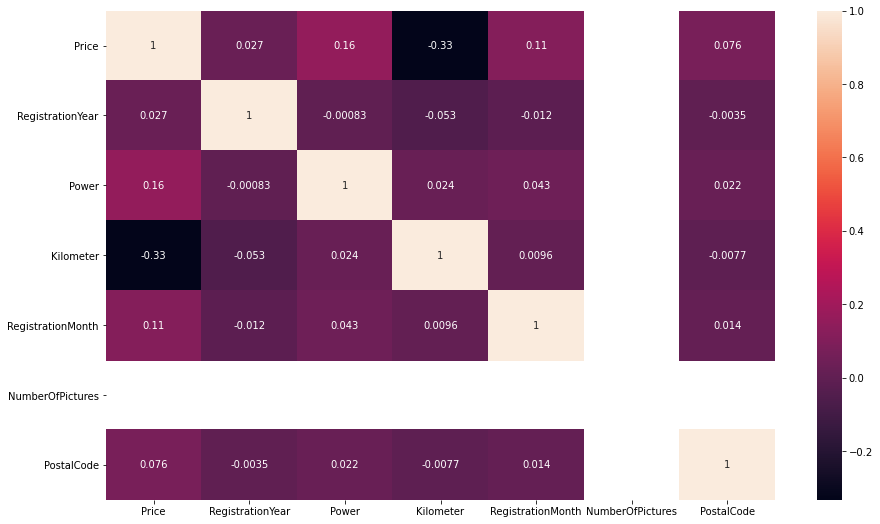

In [9]:
heat = df.corr()
ax = plt.subplots(figsize=(15, 9))
sns.heatmap(heat, annot=True);

In [10]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


**Сильно скоррелированные признаки отсутствуют**

In [11]:
print(df['NumberOfPictures'].sum())
print(df['Kilometer'].unique())
print('Количество признаков в столбце Kilometer со значением более 149к:', (df['Kilometer'] == 150000).sum())

0
[150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]
Количество признаков в столбце Kilometer со значением более 149к: 238209


**Количество километража равному 150к километру: 238209.**

**Количество фото везде 0, удалим**

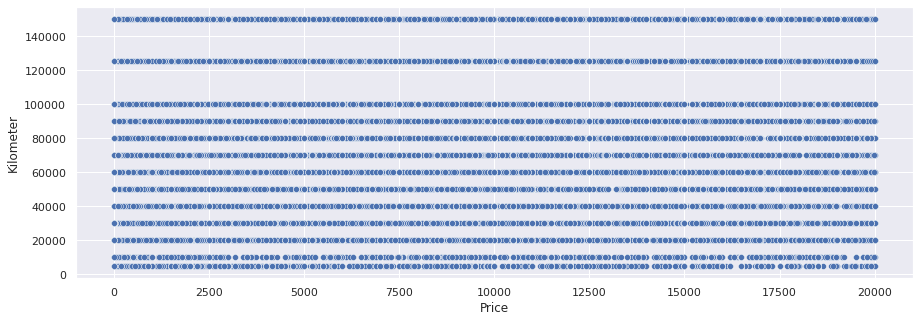

In [12]:
sns.set(rc={'figure.figsize':(15,5)})
sns.scatterplot(data=df, x='Price', y='Kilometer');

In [14]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [15]:
df.groupby(['VehicleType']).count()

,DateCrawled,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
VehicleType,,,,,,,,,,,,,,,
bus,28775,28775,28775,27973,28775,27794,28775,28775,27741,28775,25197,28775,28775,28775,28775
convertible,20203,20203,20203,19522,20203,19319,20203,20203,19338,20203,17526,20203,20203,20203,20203
coupe,16163,16163,16163,15704,16163,15239,16163,16163,15344,16163,13393,16163,16163,16163,16163
other,3288,3288,3288,3048,3288,2804,3288,3288,2941,3288,2136,3288,3288,3288,3288
sedan,91457,91457,91457,89048,91457,88119,91457,91457,87441,91457,77617,91457,91457,91457,91457
small,79831,79831,79831,76629,79831,76494,79831,79831,75045,79831,64891,79831,79831,79831,79831
suv,11996,11996,11996,11661,11996,11237,11996,11996,11579,11996,10569,11996,11996,11996,11996
wagon,65166,65166,65166,63431,65166,62996,65166,65166,61850,65166,54967,65166,65166,65166,65166


In [16]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [17]:
df.groupby(['Gearbox']).count()

,DateCrawled,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
Gearbox,,,,,,,,,,,,,,,
auto,66285,66285,62287,66285,66285,63038,66285,66285,62451,66285,56323,66285,66285,66285,66285
manual,268251,268251,244729,268251,268251,255924,268251,268251,248110,268251,219847,268251,268251,268251,268251


In [18]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [19]:
df.groupby(['FuelType']).count()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
FuelType,,,,,,,,,,,,,,,
cng,565,565,514,565,551,565,544,565,565,565,509,565,565,565,565
electric,90,90,87,90,78,90,66,90,90,90,78,90,90,90,90
gasoline,98720,98720,93744,98720,95126,98720,95857,98720,98720,98720,84043,98720,98720,98720,98720
hybrid,233,233,218,233,227,233,208,233,233,233,214,233,233,233,233
lpg,5310,5310,4998,5310,5174,5310,4962,5310,5310,5310,4345,5310,5310,5310,5310
other,204,204,173,204,150,204,133,204,204,204,113,204,204,204,204
petrol,216352,216352,201545,216352,209255,216352,207162,216352,216352,216352,177599,216352,216352,216352,216352


In [20]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

**Смотрим уникальные значения категориальных признаков.**

**Моделей слишком много, далее они внесут свою лепту после обработки энкодером, линейная регрессия будет выдавать просто адски неверные результаты, потому пришлось удалить такой признак полностью.**

### Промежуточный вывод:

**Требуется обработка названий столбцов, выбросов, изменение типа данных**

## Предобработка данных

In [21]:
df.duplicated().sum()
print(df.shape)
df.drop_duplicates(inplace=True)
df.shape

(354369, 16)


(354365, 16)

**Удаляем дубликаты.**

In [22]:
useless = ['LastSeen', 'DateCreated', 'DateCrawled', 'RegistrationMonth', 
           'PostalCode', 'NumberOfPictures']

**Признак Kilometer удаляем так-как больше трети данных в нём равны одному значению.**

In [23]:
df = df.drop(useless, axis=1)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [25]:
for ini_str in df.columns:
    res_list = []
    res_list = re.findall('[A-Z][^A-Z]*', ini_str)
    res_list = '_'.join(res_list).lower()
    df.rename(columns = {ini_str:res_list}, inplace=True)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Оставшиеся столбцы приводим в питоний вид.**

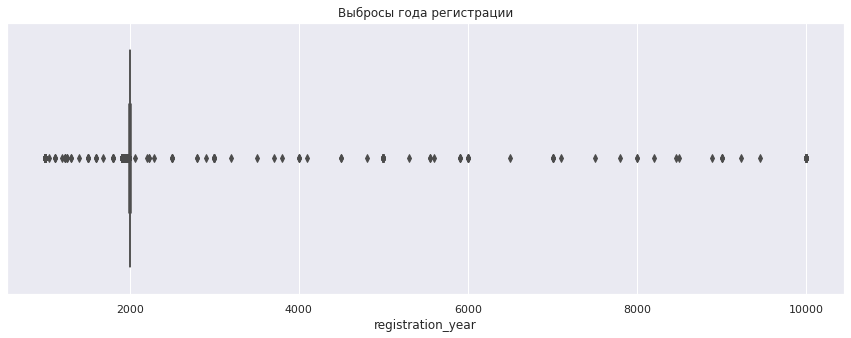

In [26]:

sns.boxplot(df['registration_year']).set_title('Выбросы года регистрации');

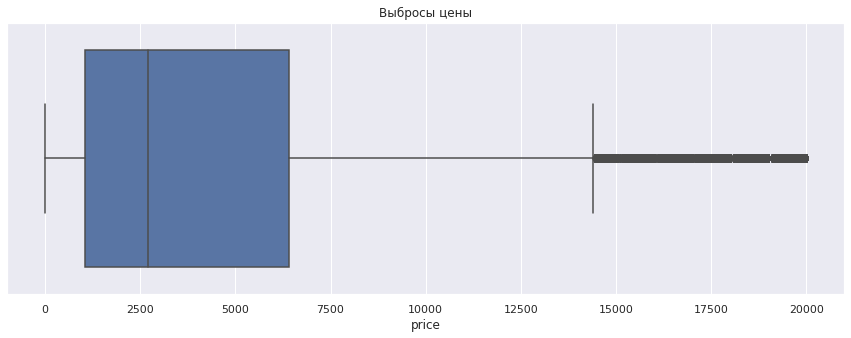

In [27]:
sns.boxplot(df['price']).set_title('Выбросы цены');

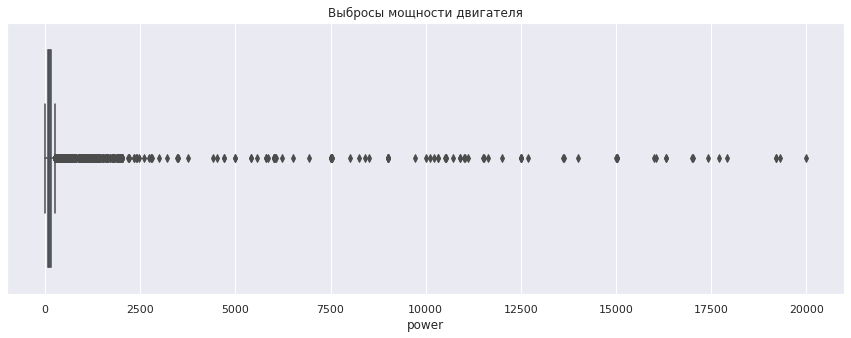

In [28]:
sns.boxplot(df['power']).set_title('Выбросы мощности двигателя');

**Смторим выбросы, далее удаляем их.**

In [29]:
print(df.shape)
df = df.loc[(df['price'] > 100) & (df['price'] < 19000)]

(354365, 10)


In [30]:
df = df.loc[(df['power'] > 30) & (df['power'] < 350)]

In [31]:
df = df.loc[(df['registration_year'] > 1985) & (df['registration_year'] < 2017)]
print(df.shape)

(287038, 10)


In [32]:
print(display(df.describe()))

,price,registration_year,power,kilometer
count,287038.000000,287038.000000,287038.000000,287038.000000
mean,4713.831033,2003.162003,119.857768,129090.120472
std,4392.354805,5.658587,50.897742,35978.149726
min,101.000000,1986.000000,31.000000,5000.000000
25%,1350.000000,1999.000000,77.000000,125000.000000
50%,3100.000000,2003.000000,110.000000,150000.000000
75%,6900.000000,2007.000000,150.000000,150000.000000
max,18999.000000,2016.000000,349.000000,150000.000000


None


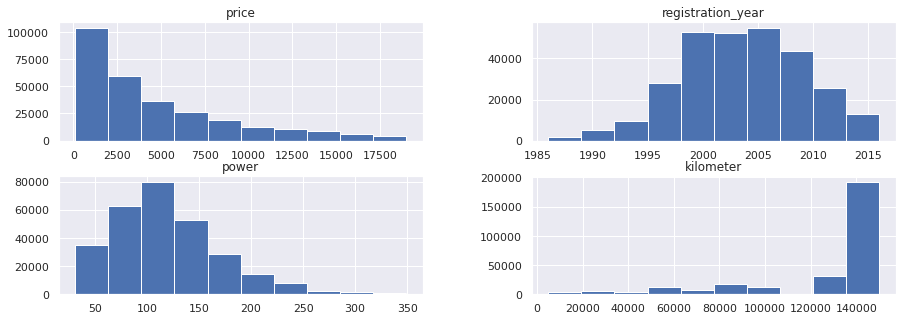

In [33]:
df.hist(figsize=(15, 5));

**Более менее порядок.**

In [34]:
df['registration_year'] = df['registration_year'].astype(str)

**Год регистрации в категориальный признак.**

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287038 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              287038 non-null  int64 
 1   vehicle_type       276615 non-null  object
 2   registration_year  287038 non-null  object
 3   gearbox            282022 non-null  object
 4   power              287038 non-null  int64 
 5   model              276997 non-null  object
 6   kilometer          287038 non-null  int64 
 7   fuel_type          272267 non-null  object
 8   brand              287038 non-null  object
 9   repaired           245915 non-null  object
dtypes: int64(3), object(7)
memory usage: 24.1+ MB


**Далее делим сет на две выборки.**

In [36]:
X = df.drop('price', axis=1)
y = df['price']          # Разделяем выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Порядок.**

In [37]:
num = [x for x in X_train.columns if X_train[x].dtype!='object']
cat = [x for x in X_train.columns if X_train[x].dtype=='object'] # Создаём списки категориальных и нумерных колонок.

**К слову у нас только одна не категориальная колонка.)) это power ))**

**Далее был вынужден сделать так - линейную регрессию получилось сделать через пайплайн, это нам показали на вебинаре.**

**Но далее пошли сложности, я несколько часов пытался запихать в пайп разные модели, и одновременно с этим ещё и соеденить с gridsearchcv, очень долго натыкался то на одни то на другие ошибки, в конце концов я подумал что хватит, вообще пора уже сдавать проект, в прочем для меня это был очень полезный и увлекательный опыт, к сожалению без видимых результатов.**

In [40]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

**Прохожу энкодером по выборкам, я думал что лучше пройтись им до разделения выборок, но почему-то встречаю примеры именно после разделения, решил сделать так-как видел в примерах.**

**Настройка пайплайна**

In [41]:
# Imputer - способ заполнения пропусков
#simple_imputer = SimpleImputer(strategy='median') ('imputer', simple_imputer)
#Scaler - способо масштабирования
std_scaler = StandardScaler()
# Конвеер трансформации числовых столбцов
pipe_num = Pipeline([('scaler', std_scaler)])

In [42]:
s_imputer = SimpleImputer(strategy='constant', fill_value='unknown')

In [43]:
# Конвеер трансформации категориальнов столбцов     
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', encoder_ohe)])

# Ветвление трансформеров
col_transformer = ColumnTransformer([('num_preproc', pipe_num, num),
                                     ('cat_preproc', pipe_cat, cat)])

### Промежуточный вывод:

**Столбцы мешающие обучению моделей удалены, удален один столбец с категориальными признакми который в дальнейшем оказывал негативное влияние на обучение моделей.**

**Названия столбцов приведены в питоний вид, удалены выбросы**

**Пропуски оставлены в виде отдельной категории.**

**Настроен пайплайн для линейной регрессии**

**Отдельно скалированы числовые признаки, а также энкодером прошлись по категориальным признакам.**

## Обучение моделей

### LinearRegression

In [44]:
%%time
model=LinearRegression()
final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model)])

final_pipe.fit(X_train, y_train)

CPU times: user 24.5 s, sys: 29.7 s, total: 54.2 s
Wall time: 54.8 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_preproc',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer']),
                                                 ('cat_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired'])])),
                ('model', LinearRegression())])

In [45]:
%%time
scores = cross_val_score(final_pipe, X_train, y_train, cv=3, scoring = 'neg_root_mean_squared_error')

CPU times: user 58.7 s, sys: 1min 11s, total: 2min 10s
Wall time: 2min 11s


In [46]:
print('RMSE модели на кроссвалидационной выборке:', (scores*-1).sum()/3)

RMSE модели на кроссвалидационной выборке: 1928.2275892886676


In [47]:
%%time
predictions = final_pipe.predict(X_train)

CPU times: user 592 ms, sys: 13.5 ms, total: 605 ms
Wall time: 604 ms


**Пока возился со всеми этими признаками, обратил внимание на то что выпадают отрицательные предсказания! Далее решил проверять их везде что в конечном итоге изменило выбор лучшей модели.**

### LightGBM

In [84]:
model_lg = LGBMRegressor()

params = {
    'model__num_leaves': [7, 15],
    'model__learning_rate': [0.9],
    'model__max_depth': [None],
    'model__n_estimators': [3, 7, 15],
    'model__random_state': [42],
    'model__num_iterations': [15],
}

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_lg)])

grid = GridSearchCV(final_pipe, param_grid = params, cv=3, scoring='neg_root_mean_squared_error')

In [85]:
%%time
grid.fit(X_train, y_train)

CPU times: user 57.5 s, sys: 361 ms, total: 57.9 s
Wall time: 58.1 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num_preproc',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['power',
                                                                          'kilometer']),
                                                                        ('cat_preproc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['vehicle_type',
                                                                          'registration_year',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired'])])),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__learning_rate': [0.9],
                         'model__max_depth': [None],
                         'model__n_estimators': [3, 7, 15],
                         'model__num_iterations': [15],
                         'model__num_leaves': [7, 15],
                         'model__random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [86]:
lg_param = grid.best_params_
lg_score = grid.best_score_

print('Лучшие гиперпараметры модели')
print(lg_param)

print('score:')
print('LGBMRegressor RMSE:', lg_score*-1)

Лучшие гиперпараметры модели
{'model__learning_rate': 0.9, 'model__max_depth': None, 'model__n_estimators': 3, 'model__num_iterations': 15, 'model__num_leaves': 15, 'model__random_state': 42}
score:
LGBMRegressor RMSE: 1805.341922392401


In [97]:
%%time
model_lg = LGBMRegressor(learning_rate = 0.9, 
                         max_depth = None, 
                         n_estimators = 3, 
                         num_iterations = 15,
                         num_leaves = 15, 
                         random_state= 42)

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_lg)])

LGBMR = final_pipe.fit(X_train, y_train)

CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s
Wall time: 1.57 s


In [98]:
%%time
predictions = LGBMR.predict(X_train)

CPU times: user 738 ms, sys: 0 ns, total: 738 ms
Wall time: 727 ms


**В LightGBM менял такие гиперпараметры как num_leaves, num_boost_round, learning_rate. Все параметры улучшали результат при увелечении значения самого параметра**

**В конечном итоге при работе обучения в 40 секунд результат RMSE давал 1700, результат можно сказать не отличается от того что выбран сейчас, а учится всего 2.4 секунды.**

### Модели: RandomForestRegressor и DecisionTreeRegressor.

In [64]:
%%time
model_DT = DecisionTreeRegressor()

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_DT)])

params_DT = {
    'model__max_depth':[None] + [i for i in range(2, 7)],
    'model__random_state': [42]
}

grid_DT = GridSearchCV(final_pipe, param_grid = params_DT, cv=3, scoring='neg_root_mean_squared_error')


grid_DT.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 156 ms, total: 1min 49s
Wall time: 1min 50s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num_preproc',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['power',
                                                                          'kilometer']),
                                                                        ('cat_preproc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['vehicle_type',
                                                                          'registration_year',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired'])])),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__max_depth': [None, 2, 3, 4, 5, 6],
                         'model__random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [65]:
print('Лучшие гиперпараметры')
print(grid_DT.best_params_)

print('score:')
print('DecisionTreeRegressor RMSE:', grid_DT.best_score_*-1)

Лучшие гиперпараметры
{'model__max_depth': None, 'model__random_state': 42}
score:
DecisionTreeRegressor RMSE: 1818.875632648292


In [66]:
%%time
model_DT = DecisionTreeRegressor(max_depth = None, random_state = 42)

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_DT)])

final_pipe.fit(X_train, y_train)

CPU times: user 35.8 s, sys: 101 ms, total: 35.9 s
Wall time: 36.4 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_preproc',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer']),
                                                 ('cat_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [67]:
%%time
predictions = grid_DT.predict(X_train)

CPU times: user 674 ms, sys: 7.75 ms, total: 681 ms
Wall time: 691 ms


**Отдельно копался в настройках подгоняя под быстрый результат.**

**Максимальное значение на DT получал примерно такой-же как у LightGBM но время обучения получалось уже полторы минуты, и можно было и далее увеличивать, но решил всё таки подобрать более слабый результат с более высокой скоростью обучения.. )**

**Результат DT вполне себе годный**

### Промежуточный вывод:

* **LinearRegression ошибка в ~1900 RMSE, время обучения 54 секунды, время предсказания 6 секунд.**
* **LGBM Regressor ошибка в ~1800 RMSE, время поиска лучшей модели 1 минута, время обучения лучшей модели 1.5 секунды, время предсказания 7 секунд.**
* **RandomForestRegression ошибка в ~1550 RMSE, время поиска лучшей модели 22 минуты(google colab), время обучения лучшей модели 38 секунд, время предсказания 2 секунды.**
* **DecisionTreeRegression ошибка в ~1800 RMSE, время поиска лучшей модели 2 минуты, время обучения лучшей модели 36 секунд, время предсказания 7 секунд.**


## Анализ моделей

### LinearRegression

* **LinearRegression ошибка в ~1900 RMSE, время обучения 54 секунды, время предсказания 6 секунд.**
* **Хорошие показатели, немного уступает LGBM Regressor в плане RMSE.**

### LightGBM

* **LGBM Regressor ошибка в ~1800 RMSE, время поиска лучшей модели 1 минута, время обучения лучшей модели 1.5 секунды, время предсказания 7 секунд.**
* **Показывает наилучшие результаты, имеет наибольший потенциал в том плане что если надо то можно улучшить результат за счёт скорости обучения, либо более грамотного выбора поиска гиперпараметров.**

### RandomForestRegressor

* **RandomForestRegression ошибка в ~1550 RMSE, время поиска лучшей модели 22 минуты(google colab), время обучения лучшей модели 38 секунд, время предсказания 2 секунды.**
* **Наилучший результат в плане RMSE, но слишком долгое обучение.**

### DecisionTreeRegressor

* **DecisionTreeRegression ошибка в ~1800 RMSE, время поиска лучшей модели 2 минуты, время обучения лучшей модели 36 секунд, время предсказания 7 секунд.**
* **Хороший результат, но поиск лучшей модели в нашем проекте в два раза дольше, время обучения лучшей модели в 6 раз чем у LGBM Regressor, слишком большая разница.**

### Промежуточный вывод

**Анализ моделей выявил LGBM Regressor как лучшую модель за счёт скорости поиска параметров(1 минута), обучения лучшей модели(1.5 секунды), и хороших показателей RMSE(1800).**

## Проверка лучшей модели на тестовой выборке.

In [100]:
pred = LGBMR.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = mse**(0.5)
print('RMSE лучшей модели на тестовой выборке: %.2f' % rmse)

RMSE лучше модели на тестовой выборке: 1797.72


**Замечательный результат.**

**Проверка дамми регрессором.**

In [101]:
dummy = DummyRegressor(strategy='median')

dummy.fit(X_train, y_train)

predict = dummy.predict(X_test)

mse = mean_squared_error(y_test, predict)
rmse = mse**(0.5)
print("RMSE: %.2f" % rmse)

RMSE: 4695.88


**Дамми показывает что наша модель намного лучше!**

## Вывод:

### Загрузка данных.
* **При знакомстве с данными выяснилось что требуется обработка названий столбцов, выбросов, изменение типа данных**

### Предобработка данных.
* **Выполнена предобработка данных удалены столбцы не влияющие на цену.**
* **Названия столбцов приведены в питоний вид, удалены выбросы.**
* **Пропуски оставлены в виде отдельной категории.** 
* **Настроен пайплайн, включающий в себя eho_encoder, StandardScaler.**


### Обучение моделей.

* **Обучены 4 следующие модели LinearRegression, LGBMRegressor, DecisionTreeRegressor, RandomForestRegressor.**
* **У моделей проведены замеры времени поиска лучшей модели, время обучения лучшей модели, время предсказания.**

### Анализ моделей.
* **Анализ моделей выявил LGBM Regressor как лучшую модель за счёт скорости поиска параметров(1 минута), обучения лучшей модели(1.5 секунды), и хороших показателей RMSE(1800).**

### Проверка лучшей модели LGBM Regressor на тестовой выборке.
* **LGBM Regressor на тестовой выборке показал корень средней квадратичной ошибки в 1797.**
* **Проведенна проверка на константной модели DummyRegressor, показатель RMSE ~4000.**
* **Модель LGBM Regressor показывает отличный результат.**